In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("Datasets/SPY_30years.csv",
                   index_col="Date", parse_dates=True)


In [3]:
data.info()
# data.drop(['Dividends', 'Stock Splits', "Capital Gains"], axis=1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7263 entries, 1994-01-27 to 2022-11-30
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               7263 non-null   float64
 1   High               7263 non-null   float64
 2   Low                7263 non-null   float64
 3   Close              7263 non-null   float64
 4   Adj Close          7263 non-null   float64
 5   Volume             7263 non-null   int64  
 6   SMA_5              7263 non-null   float64
 7   SMA_20             7263 non-null   float64
 8   SMA_50             7263 non-null   float64
 9   SMA_252            7263 non-null   float64
 10  daily_return       7263 non-null   float64
 11  monthly_return     7263 non-null   float64
 12  adv20              7263 non-null   float64
 13  VWAP               7263 non-null   float64
 14  log_returns        7263 non-null   float64
 15  volatility_30      7263 non-null   float64
 16  volati

In [4]:
#Create a dataset of only the close column
df = data['Close']
# print(df.values)
dataset = df.values.reshape(-1, 1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [24]:
train, test = scaled_data[0:int(
    len(dataset) * 0.7), :], scaled_data[int(len(dataset) * 0.7):, :]
print(test.shape)


(2179, 1)


In [23]:
def reconstruct_data(data, n=1):
    data = pd.DataFrame(data)
    x, y = [], []
    
    for i in range(len(data) - n - 1):
        x.append(data.iloc[i:(i + n), :])
        # append close price
        y.append(data.iloc[i + n, 0])

    return (np.array(x), np.array(y))


train_x, train_y = reconstruct_data(train, 5)
test_x, test_y = reconstruct_data(test, 5)
print(train_x.shape, train_y.shape)
print(test_y.shape, test_y.shape)


(5078, 5, 1) (5078,)
(2173,) (2173,)


In [8]:
from keras import callbacks
n_splits = 5
#tscv = TimeSeriesSplit(n_splits=n_splits)


def model_lstm(window, features):

    # current best
    model4 = Sequential()
    model4.add(LSTM(300, input_shape=(window, features), return_sequences=True))
    model4.add(Dropout(0.5))
    model4.add(LSTM(200, input_shape=(window, features), return_sequences=True))
    model4.add(Dropout(0.5))
    model4.add(LSTM(100, input_shape=(window, features), return_sequences=False))
    model4.add(Dropout(0.5))
    model4.add(Dense(1))
    model4.compile(loss='mse', optimizer='adam')

    # test model
    model = Sequential()
    model.add(LSTM(100, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(50, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(25, input_shape=(window, features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    # from kaggle
    # Test Loss: 0.000316278834361583
    model2 = Sequential()
    model2.add(LSTM(128, return_sequences=True,
               input_shape=(window, features)))
    model2.add(LSTM(64, return_sequences=False))
    model2.add(Dense(25))
    model2.add(Dense(1))
    model2.compile(loss='mse', optimizer='adam')
    
    model3 = Sequential()
    model3.add(LSTM(100, return_sequences=True,
               input_shape=(window, features)))
    #model3.add(Dropout(0.5))
    model3.add(LSTM(50, return_sequences=False))
    #model3.add(Dropout(0.5))
    model3.add(Dense(30))
    model3.add(Dense(1))
    model3.compile(loss='mse', optimizer='adam')

    return model3

    # return model4


earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=10,
                                        restore_best_weights=True)


Epoch 1/100
318/318 - 10s - loss: 4.6407e-04 - 10s/epoch - 32ms/step
Epoch 2/100
318/318 - 3s - loss: 2.9142e-05 - 3s/epoch - 10ms/step
Epoch 3/100
318/318 - 3s - loss: 3.2550e-05 - 3s/epoch - 11ms/step
Epoch 4/100
318/318 - 3s - loss: 3.0221e-05 - 3s/epoch - 11ms/step
Epoch 5/100
318/318 - 4s - loss: 2.9449e-05 - 4s/epoch - 11ms/step
Epoch 6/100
318/318 - 3s - loss: 2.9407e-05 - 3s/epoch - 10ms/step
Epoch 7/100
318/318 - 3s - loss: 2.7612e-05 - 3s/epoch - 11ms/step
Epoch 8/100
318/318 - 4s - loss: 2.8338e-05 - 4s/epoch - 11ms/step
Epoch 9/100
318/318 - 3s - loss: 2.9362e-05 - 3s/epoch - 11ms/step
Epoch 10/100
318/318 - 3s - loss: 2.5763e-05 - 3s/epoch - 11ms/step
Epoch 11/100
318/318 - 4s - loss: 2.6091e-05 - 4s/epoch - 11ms/step
Epoch 12/100
318/318 - 4s - loss: 2.4743e-05 - 4s/epoch - 11ms/step
Epoch 13/100
318/318 - 4s - loss: 2.3976e-05 - 4s/epoch - 12ms/step
Epoch 14/100
318/318 - 3s - loss: 2.1582e-05 - 3s/epoch - 9ms/step
Epoch 15/100
318/318 - 4s - loss: 1.9183e-05 - 4s/epoch 

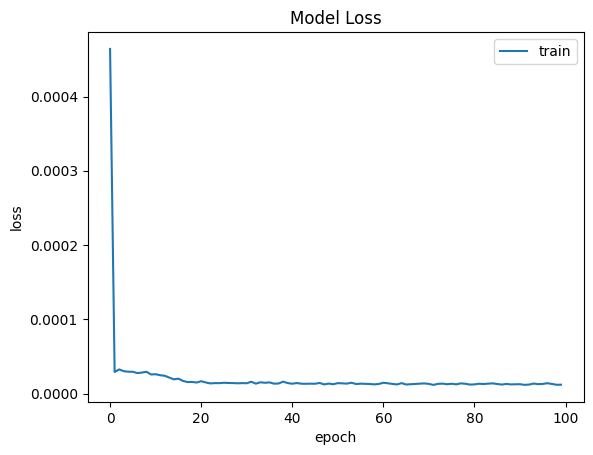

In [9]:
model = model_lstm(5, 1)
train_x = np.reshape(train_x, (train_x.shape[0],  train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))


history = model.fit(train_x, train_y, epochs=100, batch_size=16, verbose=2)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [10]:
test_loss = model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)


68/68 [==============================] - 2s 6ms/step - loss: 6.5264e-04
Test Loss: 0.0006526427459903061


159/159 [==============================] - 2s 5ms/step


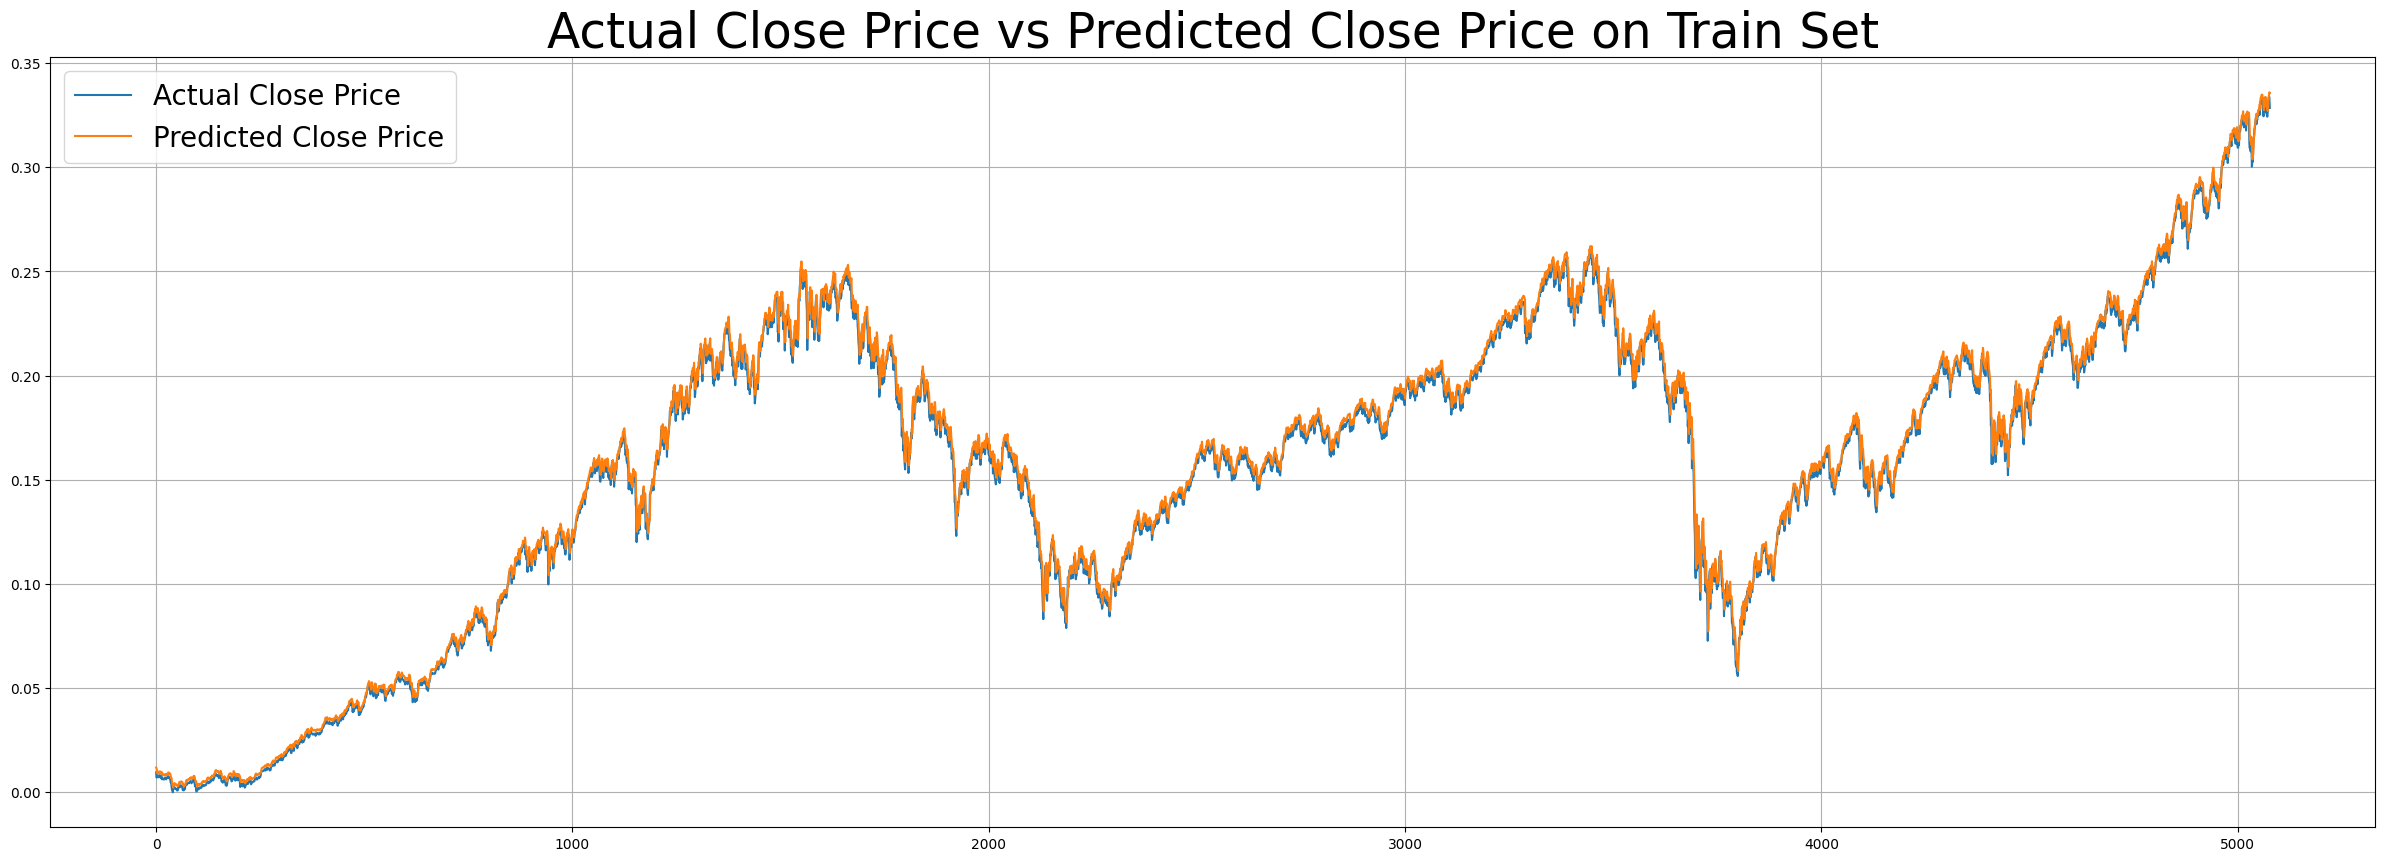

In [11]:
y_predicted = model.predict(train_x)

# unscaled_predicted = scaler.inverse_transform(y_predicted)

plt.figure(figsize=(30, 10))
plt.plot(train_y, label="Actual Close Price")
plt.plot(y_predicted, label="Predicted Close Price")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual Close Price vs Predicted Close Price on Train Set", fontsize=35)
plt.show()


68/68 [==============================] - 0s 5ms/step


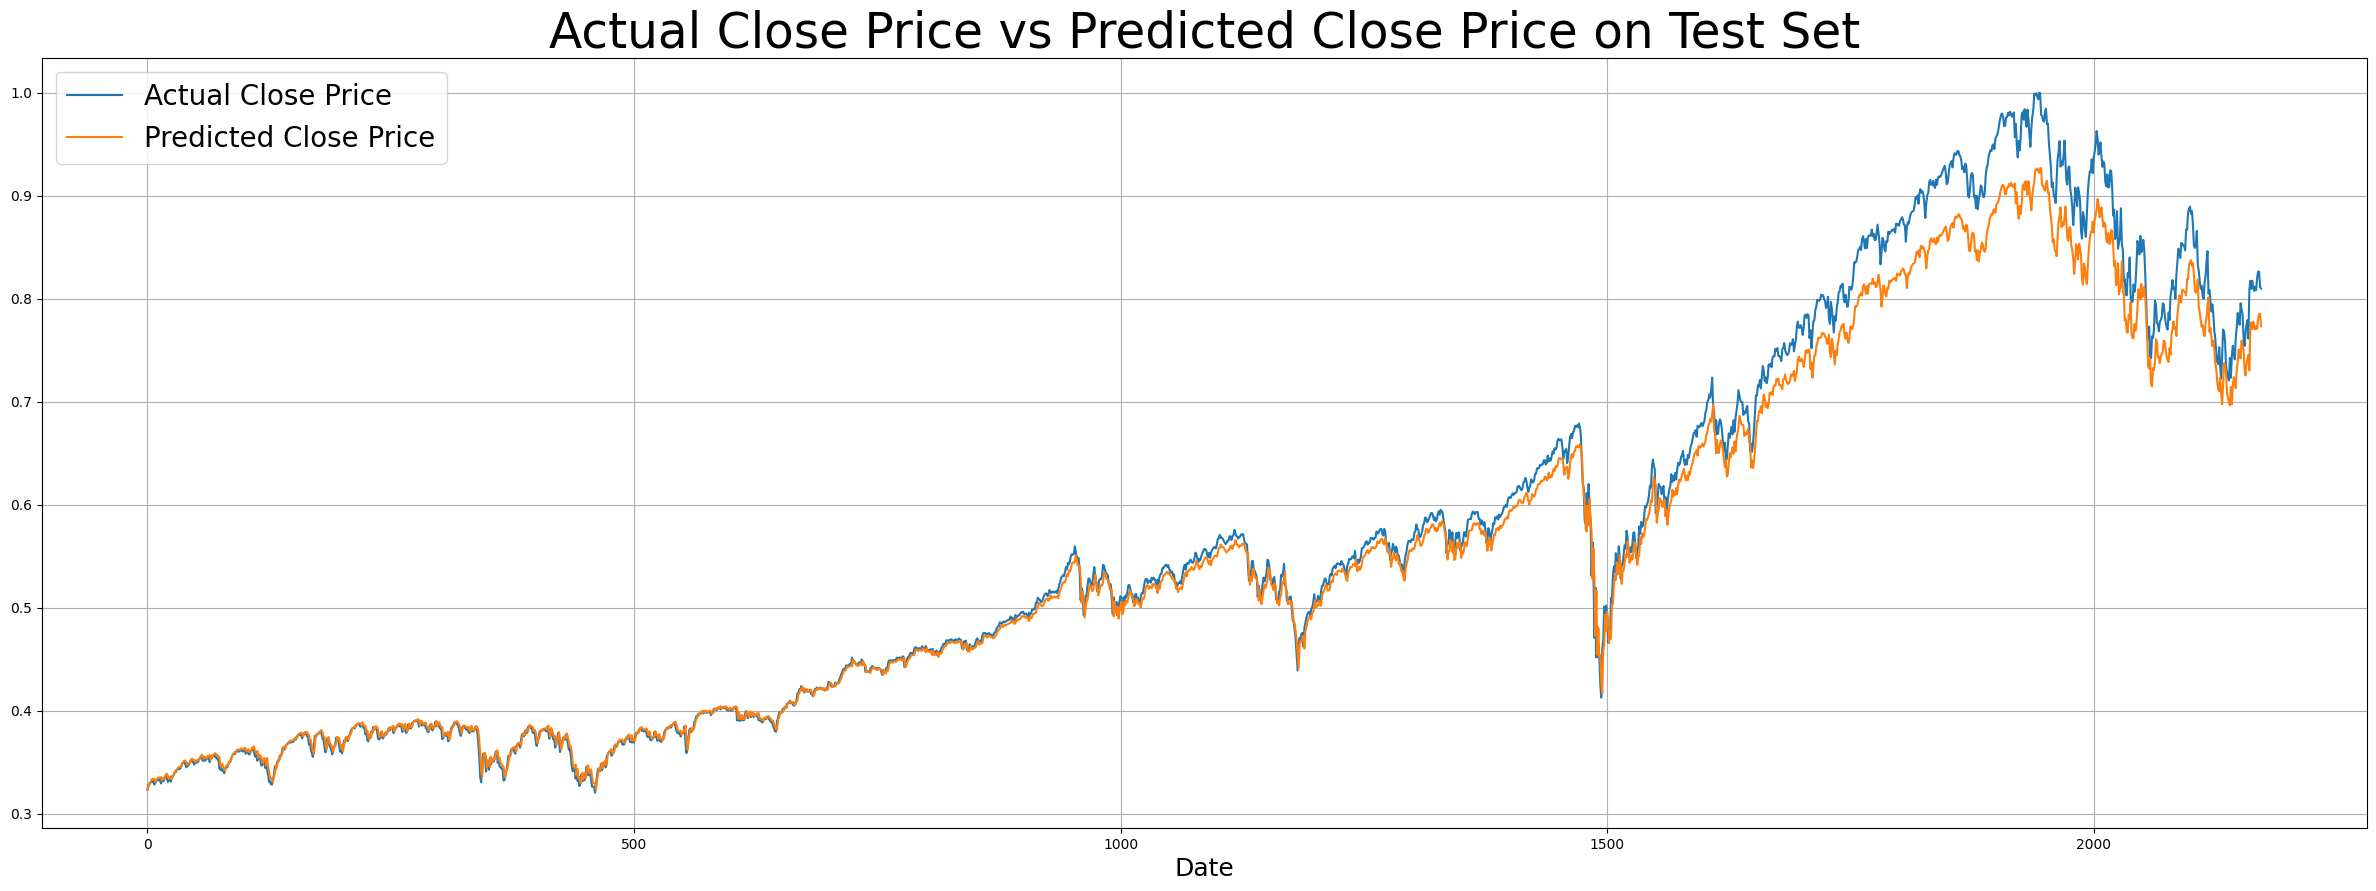

In [12]:
# Predicting Testing Dataset
test_predict = model.predict(test_x)
# test_predict = scaler.inverse_transform(test_predict)
# test_labels = scaler.inverse_transform(test_y)

plt.figure(figsize=(30, 10))
plt.plot(test_y, label="Actual Close Price")
plt.xlabel('Date', fontsize=18)
plt.plot(test_predict, label="Predicted Close Price")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual Close Price vs Predicted Close Price on Test Set", fontsize=35)
plt.show()


In [13]:
#print(test_predict.shape)
predictions = scaler.inverse_transform(test_predict)
#test_y_real = test_y.reshape(-1, 1)
test_y_real = scaler.inverse_transform(test_y.reshape(-1, 1))


# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - test_y_real) ** 2)))
print(f"RMSE: {rmse}")



RMSE: 11.082323659919679


In [38]:
#Create dataset of actual close price and predicted close price
final_df = pd.DataFrame({'Actual Close Price': test_y_real.flatten(), 'Predicted Close Price': predictions.flatten()})
print(final_df)

print(data[int(len(dataset) * 0.7):].head(10))


final_df.index = data[int(len(dataset) * 0.7)+5: -1].index
print(final_df)


      Actual Close Price  Predicted Close Price
0             184.199997             184.221664
1             186.130005             185.322708
2             186.389999             186.942505
3             187.039993             187.179276
4             187.889999             187.877380
...                  ...                    ...
2168          399.899994             378.247559
2169          402.420013             382.598663
2170          402.329987             384.599396
2171          395.910004             384.532745
2172          395.230011             379.333832

[2173 rows x 2 columns]
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-04-08  184.259995  185.399994  183.589996  185.100006  156.349152   
2014-04-09  185.600006  187.149994  185.059998  187.089996  158.030045   
2014-04-10  187.080002  187.169998  182.929993  183.160004  154.710480   
2014-04-11  182.139999  183.4

In [15]:
#Reading in new data
import numpy as np
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline


startdate = datetime.datetime(2023, 1, 1)
enddate = datetime.datetime(2023, 1, 1)

GetSANDP500 = yf.download('SPY', start=startdate)
# df = pd.DataFrame(GetSANDP500.history(start=startdate, end=enddate))
df_new = pd.DataFrame(GetSANDP500)
#df.to_csv('SPY_raw.csv')
df_new


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,384.369995,386.429993,377.829987,380.820007,377.968140,74850700
2023-01-04,383.179993,385.880005,380.000000,383.760010,380.886139,85934100
2023-01-05,381.720001,381.839996,378.760010,379.380005,376.538910,76970500
2023-01-06,382.609985,389.250000,379.410004,388.079987,385.173737,104189600
2023-01-09,390.369995,393.700012,387.670013,387.859985,384.955383,73978100
...,...,...,...,...,...,...
2023-09-01,453.170013,453.670013,449.679993,451.190002,451.190002,58875700
2023-09-05,450.730011,451.059998,449.170013,449.239990,449.239990,55166200
2023-09-06,448.399994,448.510010,443.809998,446.220001,446.220001,70758500


In [16]:
#df_new.to_csv('SPY_input.csv')
df_new.iloc[0, :]


Open         3.843700e+02
High         3.864300e+02
Low          3.778300e+02
Close        3.808200e+02
Adj Close    3.779681e+02
Volume       7.485070e+07
Name: 2023-01-03 00:00:00, dtype: float64

In [17]:
new_row = pd.DataFrame(df_new.iloc[0, :]).transpose()

In [18]:
new_row

,Open,High,Low,Close,Adj Close,Volume
2023-01-03,384.369995,386.429993,377.829987,380.820007,377.96814,74850700.0


In [19]:
new_row_columns = new_row.assign(
    SMA_5=new_row['Close'].rolling(5).mean(),
    SMA_20=new_row['Close'].rolling(20).mean(),
    SMA_50=new_row['Close'].rolling(50).mean(),
    SMA_252=new_row['Close'].rolling(252).mean(),
    daily_return=(new_row['Close'].pct_change() * 100).round(2),
    monthly_return=(new_row['Close'].pct_change(30) * 100).round(2),
    adv20=new_row["Volume"].rolling(20).mean(),
    VWAP=(new_row['Volume'] * df['Close']).cumsum() /
    new_row['Volume'].cumsum()
)


KeyError: 'Close'

In [ ]:
data_temp = pd.concat([data, new_row], axis=0)

In [ ]:
data_temp.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_20,SMA_50,SMA_252,daily_return,monthly_return,adv20,VWAP,log_returns,volatility_30,volatility_60,annual_volatility,rapp
2022-11-25,401.829987,402.910004,401.540009,402.329987,397.491760,30545400.0,399.053998,389.491499,378.266000,416.172700,-0.02,9.94,83908015.0,172.092521,-0.000224,0.089540,0.129521,0.241507,0.947978
2022-11-28,399.089996,400.809998,395.109985,395.910004,391.148956,67881600.0,399.029999,389.836000,378.473000,415.922461,-1.60,10.70,82286995.0,172.116435,-0.016086,0.087682,0.130516,0.241003,0.951378
2022-11-29,396.049988,397.299988,393.299988,395.230011,390.477142,52310000.0,399.158002,390.287001,378.606601,415.647184,-0.17,7.74,80070930.0,172.134804,-0.001719,0.084793,0.130085,0.240664,0.970169
2022-11-30,395.489990,407.679993,393.480011,407.679993,402.777405,144566700.0,400.714001,391.445001,379.078401,415.457184,3.15,9.85,83028885.0,172.188384,0.031015,0.089059,0.133628,0.241975,0.938064
2023-01-03,384.369995,386.429993,377.829987,380.820007,377.968140,74850700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Create a dataset of only the close column
df = data_temp['Close']
dataset = df.values.reshape(-1, 1)

# Scale dataset
scaled_data = scaler.fit_transform(dataset)

train, test = scaled_data[0:int(
    len(dataset) * 0.7), :], scaled_data[int(len(dataset) * 0.7):, :]

train_x, train_y = reconstruct_data(train, 5)
test_x, test_y = reconstruct_data(test, 5)
default_test = [test_x, test_y]


[[ 47.75      ]
 [ 47.875     ]
 [ 48.21875   ]
 ...
 [395.23001099]
 [407.67999268]
 [380.82000732]]


68/68 [==============================] - 0s 2ms/step


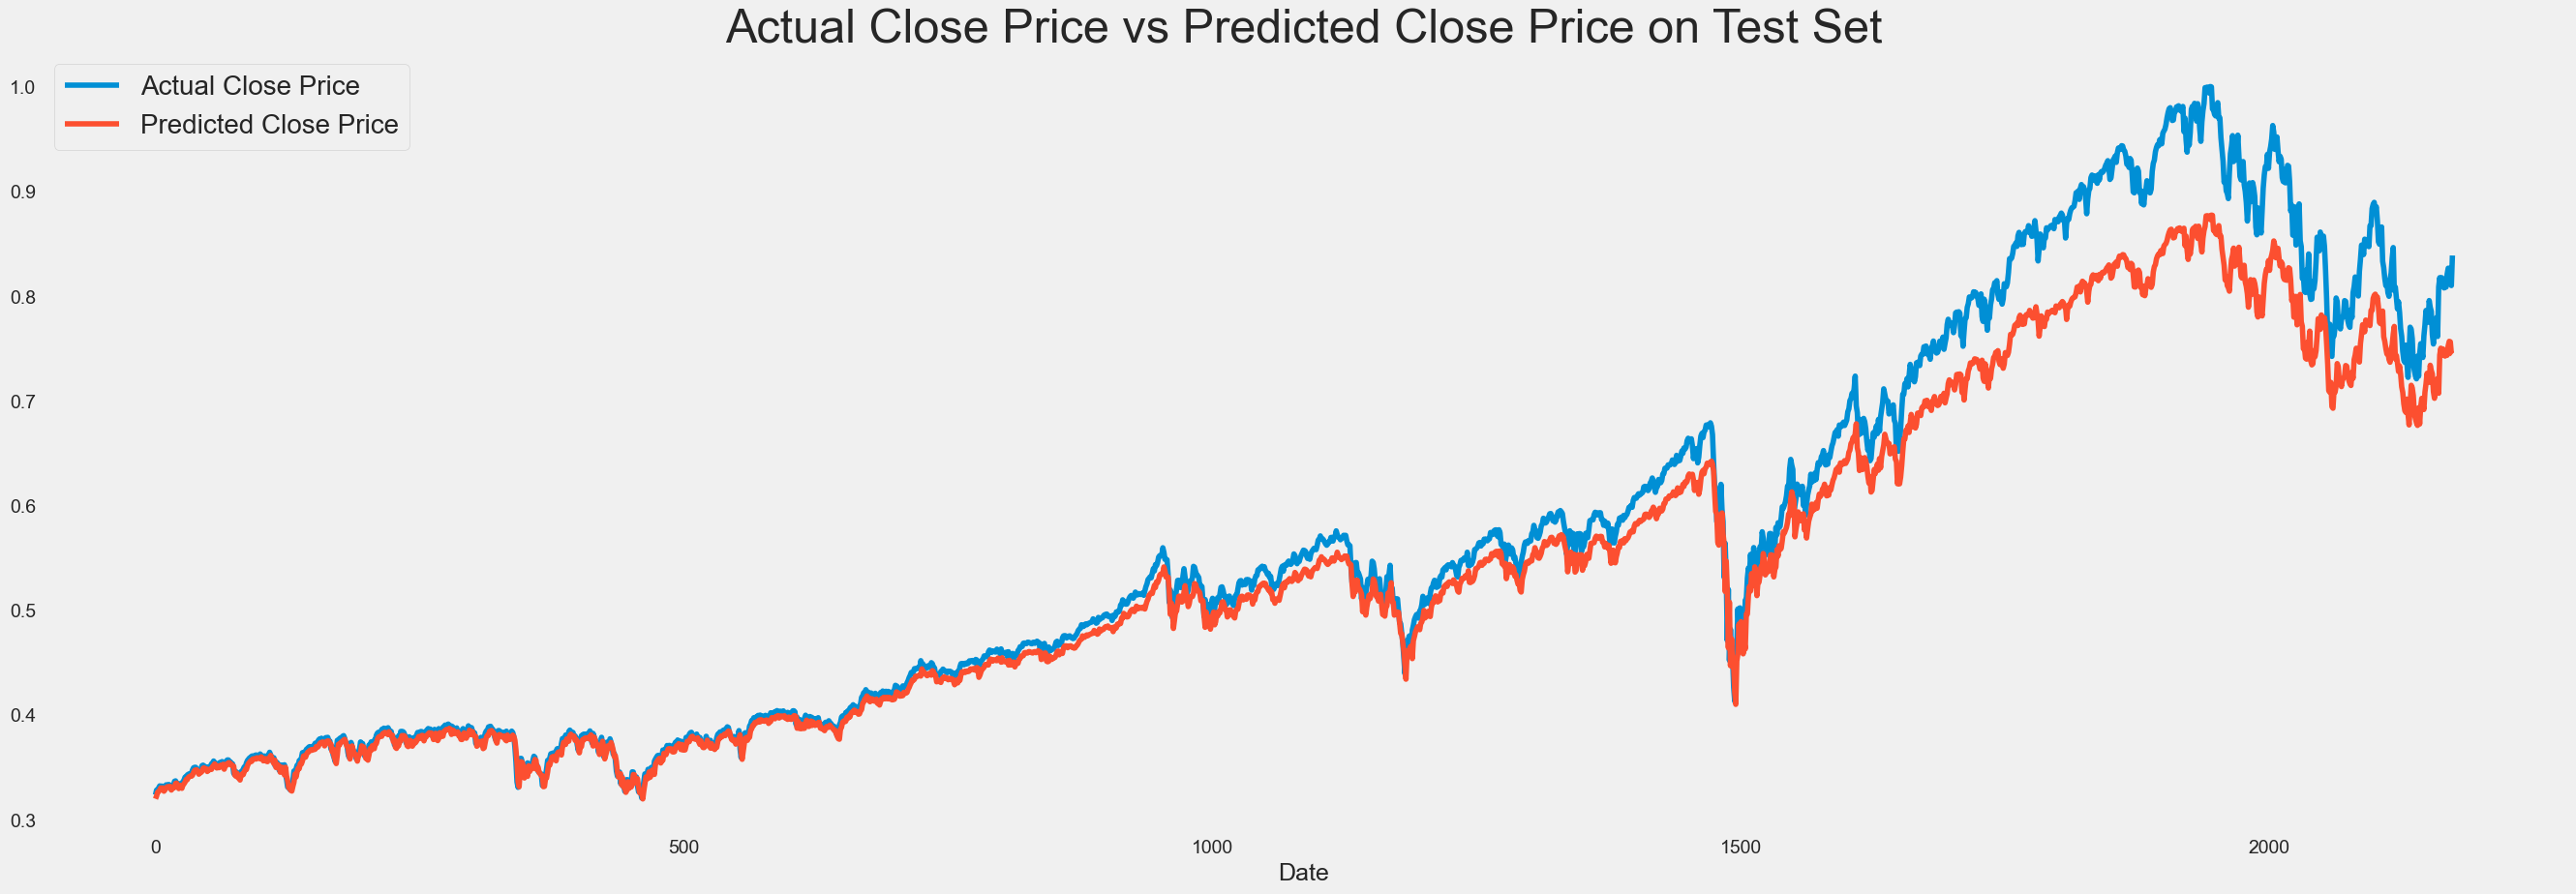

In [ ]:
# Predicting Testing Dataset
test_predict = model.predict(test_x)
# test_predict = scaler.inverse_transform(test_predict)
# test_labels = scaler.inverse_transform(test_y)

plt.figure(figsize=(30, 10))
plt.plot(test_y, label="Actual Close Price")
plt.xlabel('Date', fontsize=18)
plt.plot(test_predict, label="Predicted Close Price")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual Close Price vs Predicted Close Price on Test Set", fontsize=35)
plt.show()


In [ ]:
print(test_predict)
test_predict = scaler.inverse_transform(test_predict)

[[0.31955448]
 [0.32212582]
 [0.32593   ]
 ...
 [0.756163  ]
 [0.7450825 ]
 [0.7442659 ]]


In [ ]:
test_predict
new_price = test_predict[-1]
new_price[0]

366.7716

In [ ]:
new_data = np.array(data_temp.iloc[len(data_temp) - 5:len(data_temp), 3])
print(new_data.reshape(5,1))
print(new_data.shape)

[[402.32998657]
 [395.91000366]
 [395.23001099]
 [407.67999268]
 [380.82000732]]
(5,)


In [ ]:
predicted_value = model.predict(new_data.reshape(5,1,1))
print(predicted_value)

1/1 [==============================] - 0s 17ms/step
[[2.0321891]
 [2.0322719]
 [2.032281 ]
 [2.032123 ]
 [2.0324826]]
